In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



Dataset https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

**Libraries**

In [4]:
## import libraries
import tensorflow as tf
import keras
from keras import models, layers ,optimizers
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import glob as gb
from zipfile import ZipFile
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

**Load Data**

In [5]:
# path of image

data_path= r'/content/drive/MyDrive/new projects ai /breast cancer/images/Dataset_BUSI_with_GT'

# get the common size in images
# and the number of the images in each folder
Size=[]

for folder in os.listdir(data_path) :
    files = gb.glob(pathname= str( data_path +'/'+ folder + '/*.png'))
    print(f' found  {len(files)}  images in folder {folder}')
    for file in files:
        image = plt.imread(file)
        Size.append(image.shape)
pd.Series(Size).value_counts()

 found  891  images in folder benign
 found  266  images in folder normal
 found  421  images in folder malignant


(467, 558, 3)    7
(470, 562, 3)    7
(468, 560, 3)    6
(465, 557)       6
(598, 763, 3)    6
                ..
(531, 703)       1
(585, 783, 3)    1
(491, 555)       1
(487, 769)       1
(483, 735, 3)    1
Length: 1186, dtype: int64

In [6]:
# initializing value
BATCH_SIZE = 128
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=30

In [7]:
# load images  by keras
dataset =tf.keras.preprocessing.image_dataset_from_directory(data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1578 files belonging to 3 classes.


In [8]:
# class names
class_names = dataset.class_names
class_names

['benign', 'malignant', 'normal']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(128, 150, 150, 3)
[1 0 2 1 1 0 0 1 2 2 1 0 0 1 1 1 2 0 1 2 0 0 0 0 0 0 1 1 1 2 0 0 0 2 2 0 1
 2 0 0 1 1 0 0 0 0 1 1 0 2 0 0 1 0 0 0 0 1 1 0 1 2 1 1 0 0 0 2 2 2 0 1 0 0
 2 0 0 0 0 0 1 1 0 1 0 1 0 0 2 0 0 0 1 0 1 0 0 0 1 2 2 2 0 1 2 0 0 2 1 0 0
 0 0 0 1 1 0 0 0 0 1 1 2 2 0 0 1 0]


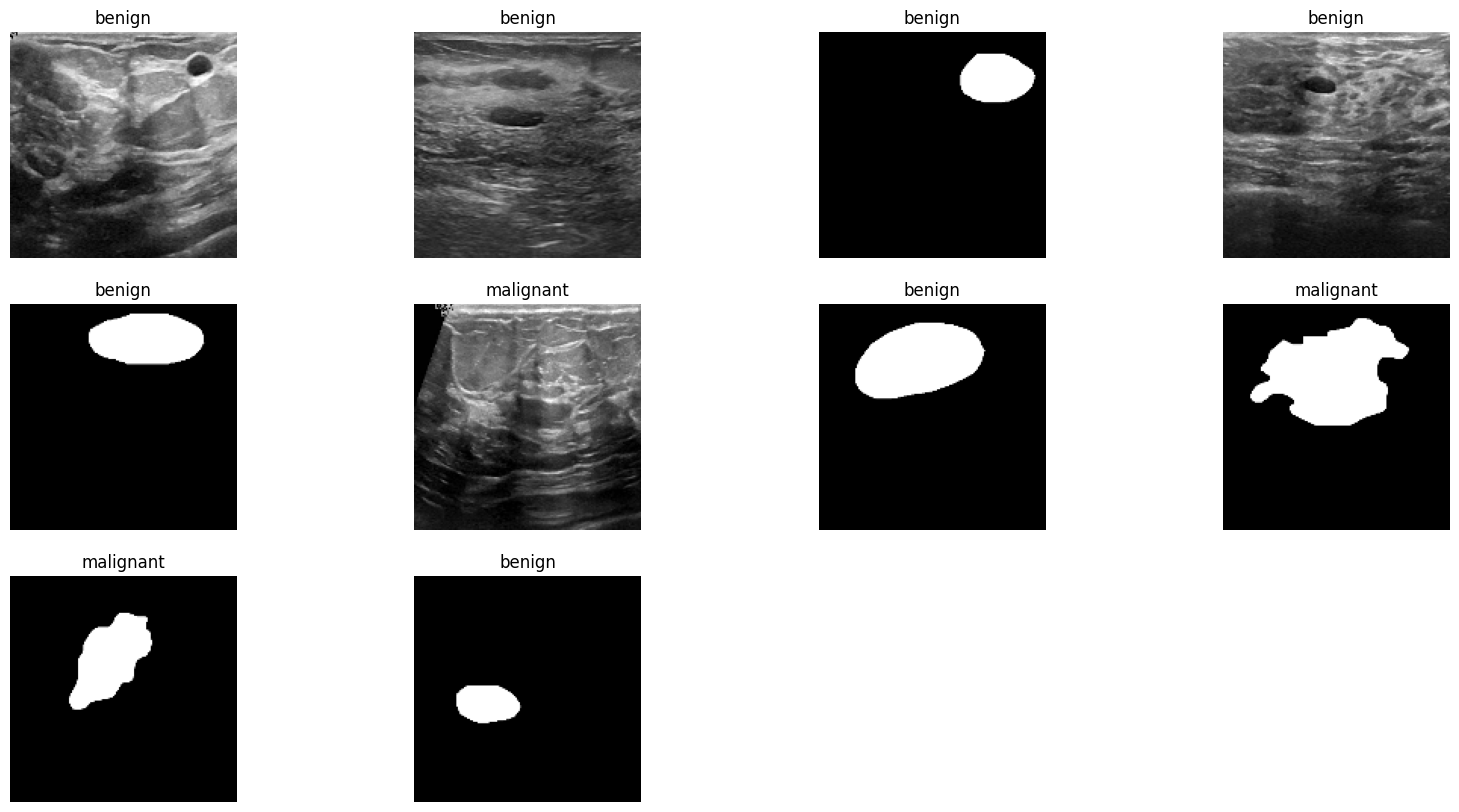

In [10]:
# show some of image
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Data Split**

In [11]:
#  function to split data (train , test, validation)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [13]:
len(train_ds),len(val_ds),len(test_ds)

(10, 1, 2)

In [14]:
# normalization data
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

**Build Model**

In [15]:
# bulid the CNN (Neural Network )
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =len(class_names)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size = (3,3), padding = "same",activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 150, 150, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 150, 150, 128)      3584      
                                                                 
 max_pooling2d (MaxPooling2D  (128, 75, 75, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 73, 73, 64)         73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 36, 36, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (128, 34, 34, 64)        

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
#train CNN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
10/10 [==============================] - 36s 1s/step - loss: 0.9730 - accuracy: 0.5025 - val_loss: 0.8635 - val_accuracy: 0.5469
Epoch 2/30
10/10 [==============================] - 17s 1s/step - loss: 0.8164 - accuracy: 0.5820 - val_loss: 0.7862 - val_accuracy: 0.5859
Epoch 3/30
10/10 [==============================] - 17s 905ms/step - loss: 0.7314 - accuracy: 0.6147 - val_loss: 0.7338 - val_accuracy: 0.5391
Epoch 4/30
10/10 [==============================] - 20s 1s/step - loss: 0.6659 - accuracy: 0.6541 - val_loss: 0.6321 - val_accuracy: 0.7188
Epoch 5/30
10/10 [==============================] - 17s 1s/step - loss: 0.6219 - accuracy: 0.7337 - val_loss: 0.6537 - val_accuracy: 0.7734
Epoch 6/30
10/10 [==============================] - 16s 912ms/step - loss: 0.5668 - accuracy: 0.7655 - val_loss: 0.6110 - val_accuracy: 0.7891
Epoch 7/30
10/10 [==============================] - 17s 905ms/step - loss: 0.4456 - accuracy: 0.8308 - val_loss: 0.4829 - val_accuracy: 0.8203
Epoch 8/30


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

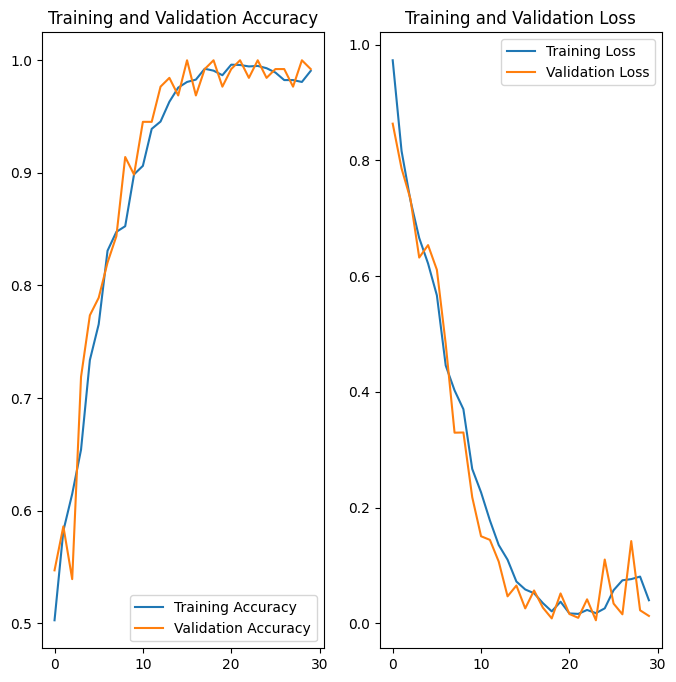

In [21]:
# show the  training & validation (accuracy & loss)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Test Model**

In [26]:
# acuuracy of the test
scores = model.evaluate(test_ds)

2/2 [==============================] - 8s 73ms/step - loss: 0.0117 - accuracy: 1.0000


first image to predict
actual label: benign
4/4 [==============================] - 0s 15ms/step
predicted label: benign
first image to predict
actual label: benign
4/4 [==============================] - 0s 15ms/step
predicted label: benign


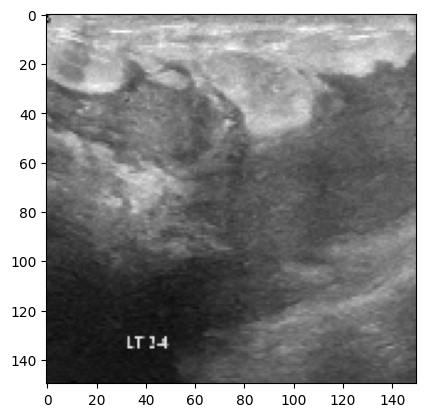

In [24]:
# the first image prdiction  vs the actual
import numpy as np
for images_batch, labels_batch in test_ds.take(2):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


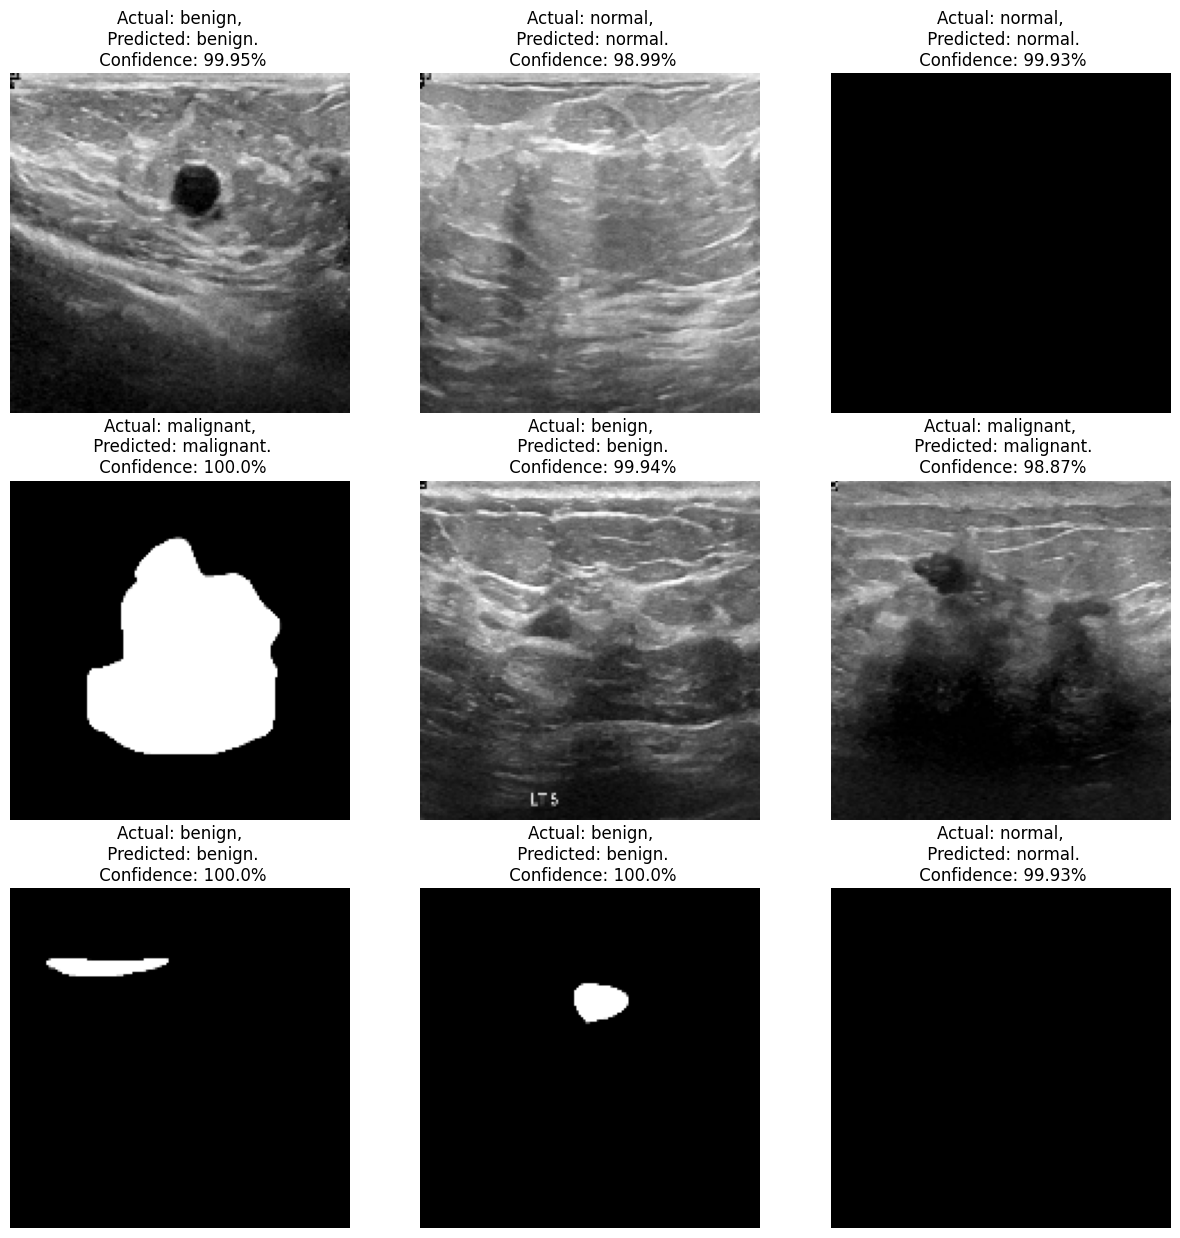

In [28]:
# show some of image  ( the prediction  vs actual )& the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Save Model**

In [25]:
# save model
model.save("breast cancer.h5")